In [3]:
from keras.layers import *
from keras.optimizers import *
from keras.datasets import *
from keras.utils import *
import matplotlib.pyplot as plt
import time
from keras.models import *
from tensorflow.examples.tutorials.mnist import input_data
from numpy import *
import PIL.Image as pic
from os import *
import scipy.misc as sp

(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train=array(x_train).reshape((60000,784))

y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)
print('d')

d


In [13]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

In [18]:
class DCGAN(object):
    def __init__(self,img_row=28,img_col=28,channel=1):
        self.img_row=img_row
        self.img_col=img_col
        self.channel=channel
        
        self.D=None
        self.G=None
        self.DM=None
        self.AM=None
    
    def discriminator(self):
        if self.D:
            return self.D
        self.D=Sequential()
        depth=64
        dropout=0.4
        
        input_shape=(self.img_row,self.img_col,self.channel)
        self.D.add(Conv2D(depth*1,5,strides=2,input_shape=input_shape,padding='same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*2,5,strides=2,padding='same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*4,5,strides=2,padding='same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Conv2D(depth*8,5,strides=2,padding='same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(dropout))
        
        self.D.add(Flatten())
        self.D.add(Dense(1,activation='sigmoid'))
        self.D.summary()
        
        return self.D
    
    def generator(self):
        if self.G:
            return self.G
        self.G=Sequential()
        depth=256
        dim=7
        dropout=0.4
        
        self.G.add(Dense(depth*dim*dim,input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim,dim,depth)))
        self.G.add(Dropout(dropout))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2),5,padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4),5,padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(int(depth/8),5,padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        
        self.G.add(Conv2DTranspose(1,5,padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        
        return self.G
    
    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
        return self.DM
    
    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer=RMSprop(lr=0.0001, decay=3e-8)
        self.AM=Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
        return self.AM

In [20]:
class MNIST_DCGAN(object):
    def __init__(self):
        self.img_cols=28
        self.img_rows=28
        self.channel = 1
        
        self.x_train=input_data.read_data_sets('mnist',one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,self.img_cols, 1).astype(np.float32)
        
        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()
        
    def train(self,train_step=1000,batch_size=64,save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_step):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]

            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)

            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)
            
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            
            print(log_mesg)
            
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],noise=noise_input, step=(i+1))
                    
    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'C:\\Users\\myfamily\\Desktop\\御坂美琴\\mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "C:\\Users\\myfamily\\Desktop\\御坂美琴\\mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            #print(image)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

Extracting mnist\train-images-idx3-ubyte.gz


Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)         819456    
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_20 (Batc (None, 12544)             50176     
_________________________________________________________________
activation_24 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 14, 14, 128)       819328    
__________

0: [D loss: 0.692200, acc: 0.525391]  [A loss: 1.749664, acc: 0.000000]


1: [D loss: 0.639647, acc: 0.712891]  [A loss: 4.479067, acc: 0.000000]


2: [D loss: 0.496796, acc: 0.779297]  [A loss: 1.033688, acc: 0.019531]


3: [D loss: 0.956392, acc: 0.500000]  [A loss: 11.928646, acc: 0.000000]


4: [D loss: 0.327823, acc: 0.853516]  [A loss: 0.017988, acc: 1.000000]


5: [D loss: 0.667568, acc: 0.515625]  [A loss: 8.851553, acc: 0.000000]


6: [D loss: 0.138340, acc: 0.970703]  [A loss: 0.022482, acc: 1.000000]


7: [D loss: 0.145979, acc: 0.996094]  [A loss: 0.817384, acc: 0.464844]


8: [D loss: 0.154266, acc: 0.990234]  [A loss: 1.594352, acc: 0.183594]


9: [D loss: 0.222537, acc: 0.955078]  [A loss: 2.626884, acc: 0.046875]


10: [D loss: 0.158589, acc: 0.994141]  [A loss: 0.044211, acc: 0.996094]


11: [D loss: 0.118205, acc: 0.972656]  [A loss: 0.000071, acc: 1.000000]


12: [D loss: 0.105643, acc: 0.994141]  [A loss: 0.002003, acc: 1.000000]


13: [D loss: 0.107776, acc: 0.986328]  [A loss: 0.000214, acc: 1.000000]


14: [D loss: 0.092323, acc: 1.000000]  [A loss: 0.000809, acc: 1.000000]


15: [D loss: 0.082175, acc: 0.994141]  [A loss: 0.000503, acc: 1.000000]


16: [D loss: 0.078573, acc: 0.996094]  [A loss: 0.000669, acc: 1.000000]


17: [D loss: 0.099370, acc: 0.986328]  [A loss: 0.000024, acc: 1.000000]


18: [D loss: 0.079682, acc: 1.000000]  [A loss: 0.000157, acc: 1.000000]


19: [D loss: 0.071087, acc: 0.996094]  [A loss: 0.000047, acc: 1.000000]


20: [D loss: 0.060858, acc: 0.998047]  [A loss: 0.000157, acc: 1.000000]


21: [D loss: 0.077266, acc: 0.992188]  [A loss: 0.000009, acc: 1.000000]


22: [D loss: 0.059924, acc: 0.998047]  [A loss: 0.000044, acc: 1.000000]


23: [D loss: 0.061714, acc: 0.992188]  [A loss: 0.000001, acc: 1.000000]


24: [D loss: 0.052318, acc: 1.000000]  [A loss: 0.000010, acc: 1.000000]


25: [D loss: 0.043475, acc: 0.996094]  [A loss: 0.000013, acc: 1.000000]


26: [D loss: 0.049386, acc: 0.990234]  [A loss: 0.000001, acc: 1.000000]


27: [D loss: 0.039636, acc: 1.000000]  [A loss: 0.000021, acc: 1.000000]


28: [D loss: 0.024900, acc: 1.000000]  [A loss: 0.000067, acc: 1.000000]


29: [D loss: 0.026880, acc: 0.994141]  [A loss: 0.000020, acc: 1.000000]


30: [D loss: 0.024057, acc: 1.000000]  [A loss: 0.000021, acc: 1.000000]


31: [D loss: 0.024659, acc: 0.996094]  [A loss: 0.000000, acc: 1.000000]


32: [D loss: 0.024488, acc: 1.000000]  [A loss: 0.000034, acc: 1.000000]


33: [D loss: 0.028148, acc: 0.994141]  [A loss: 0.000000, acc: 1.000000]


34: [D loss: 0.027096, acc: 1.000000]  [A loss: 0.000539, acc: 1.000000]


35: [D loss: 0.026169, acc: 0.994141]  [A loss: 0.000000, acc: 1.000000]


36: [D loss: 0.026676, acc: 1.000000]  [A loss: 0.016938, acc: 0.996094]


37: [D loss: 0.026426, acc: 0.994141]  [A loss: 0.000001, acc: 1.000000]


38: [D loss: 0.041572, acc: 1.000000]  [A loss: 1.132666, acc: 0.652344]


39: [D loss: 1.081526, acc: 0.558594]  [A loss: 16.118101, acc: 0.000000]


40: [D loss: 7.157274, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


41: [D loss: 1.050843, acc: 0.636719]  [A loss: 15.672285, acc: 0.000000]


42: [D loss: 0.374175, acc: 0.851562]  [A loss: 15.824579, acc: 0.000000]


43: [D loss: 0.581505, acc: 0.894531]  [A loss: 0.000000, acc: 1.000000]


44: [D loss: 3.263904, acc: 0.507812]  [A loss: 16.118101, acc: 0.000000]


45: [D loss: 7.812312, acc: 0.500000]  [A loss: 16.075817, acc: 0.000000]


46: [D loss: 3.445564, acc: 0.552734]  [A loss: 0.000000, acc: 1.000000]


47: [D loss: 7.489066, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


48: [D loss: 6.947420, acc: 0.501953]  [A loss: 0.033747, acc: 0.988281]


49: [D loss: 3.127448, acc: 0.541016]  [A loss: 16.118101, acc: 0.000000]


50: [D loss: 6.998374, acc: 0.500000]  [A loss: 3.493535, acc: 0.503906]


51: [D loss: 7.890552, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


52: [D loss: 7.877960, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


53: [D loss: 7.858474, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


54: [D loss: 7.944556, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


55: [D loss: 7.812624, acc: 0.496094]  [A loss: 0.000000, acc: 1.000000]


56: [D loss: 7.773018, acc: 0.494141]  [A loss: 0.378588, acc: 0.933594]


57: [D loss: 6.763130, acc: 0.500000]  [A loss: 16.118101, acc: 0.000000]


58: [D loss: 6.702490, acc: 0.500000]  [A loss: 0.159627, acc: 0.972656]


59: [D loss: 7.217877, acc: 0.486328]  [A loss: 16.114765, acc: 0.000000]


60: [D loss: 4.345680, acc: 0.533203]  [A loss: 0.000000, acc: 1.000000]


61: [D loss: 7.971386, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


62: [D loss: 7.962077, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


63: [D loss: 7.959254, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


64: [D loss: 7.968693, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


65: [D loss: 7.971284, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


66: [D loss: 7.983255, acc: 0.496094]  [A loss: 0.000000, acc: 1.000000]


67: [D loss: 7.982001, acc: 0.496094]  [A loss: 0.000000, acc: 1.000000]


68: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


69: [D loss: 7.972067, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


70: [D loss: 7.971193, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


71: [D loss: 7.971199, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


72: [D loss: 7.973373, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


73: [D loss: 7.971486, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


74: [D loss: 7.984373, acc: 0.496094]  [A loss: 0.000000, acc: 1.000000]


75: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


76: [D loss: 7.971195, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


77: [D loss: 7.971205, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


78: [D loss: 7.978851, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


79: [D loss: 7.971194, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


80: [D loss: 7.971304, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


81: [D loss: 7.971316, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


82: [D loss: 7.971262, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


83: [D loss: 7.973802, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


84: [D loss: 7.971263, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


85: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


86: [D loss: 7.971240, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


87: [D loss: 7.971193, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


88: [D loss: 7.977072, acc: 0.496094]  [A loss: 0.000000, acc: 1.000000]


89: [D loss: 7.972929, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


90: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


91: [D loss: 7.979753, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


92: [D loss: 7.971563, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


93: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


94: [D loss: 7.975284, acc: 0.498047]  [A loss: 0.000000, acc: 1.000000]


95: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


96: [D loss: 7.971193, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


97: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


98: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


99: [D loss: 7.971199, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


100: [D loss: 7.971199, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


101: [D loss: 7.972349, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


102: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


103: [D loss: 7.971433, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


104: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


105: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


106: [D loss: 7.971194, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


107: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


108: [D loss: 7.971395, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


109: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


110: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


111: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


112: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


113: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


114: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


115: [D loss: 7.971195, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


116: [D loss: 7.971196, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


117: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


118: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


119: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


120: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


121: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


122: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


123: [D loss: 7.971551, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


124: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


125: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


126: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


127: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


128: [D loss: 7.971199, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


129: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


130: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


131: [D loss: 7.971570, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


132: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


133: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


134: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


135: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


136: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


137: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


138: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


139: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


140: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


141: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


142: [D loss: 7.971194, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


143: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


144: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


145: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


146: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


147: [D loss: 7.971193, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


148: [D loss: 7.971198, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


149: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


150: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


151: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


152: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


153: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


154: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


155: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


156: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


157: [D loss: 7.971193, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


158: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


159: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


160: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


161: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


162: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


163: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


164: [D loss: 7.971194, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


165: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


166: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


167: [D loss: 7.971193, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


168: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


169: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


170: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


171: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


172: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


173: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


174: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


175: [D loss: 7.971195, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


176: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


177: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


178: [D loss: 7.971212, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


179: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


180: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


181: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


182: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


183: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


184: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


185: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


186: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


187: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


188: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


189: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


190: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


191: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


192: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


193: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


194: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


195: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


196: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


197: [D loss: 7.971195, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


198: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


199: [D loss: 7.971210, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


200: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


201: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


202: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


203: [D loss: 7.971199, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


204: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


205: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


206: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


207: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


208: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


209: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


210: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


211: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


212: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


213: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


214: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


215: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


216: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


217: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


218: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


219: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


220: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


221: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


222: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


223: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


224: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


225: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


226: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


227: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


228: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


229: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


230: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


231: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


232: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


233: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


234: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


235: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


236: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


237: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


238: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


239: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


240: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


241: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


242: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


243: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


244: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


245: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


246: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


247: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


248: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


249: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


250: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


251: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


252: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


253: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


254: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


255: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


256: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


257: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


258: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


259: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


260: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


261: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


262: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


263: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


264: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


265: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


266: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


267: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


268: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


269: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


270: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


271: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


272: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


273: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


274: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


275: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


276: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


277: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


278: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


279: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


280: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


281: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


282: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


283: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


284: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


285: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


286: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


287: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


288: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


289: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


290: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


291: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


292: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


293: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


294: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


295: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


296: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


297: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


298: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


299: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


300: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


301: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


302: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


303: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


304: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


305: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


306: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


307: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


308: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


309: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


310: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


311: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


312: [D loss: 7.971193, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


313: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


314: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


315: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


316: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


317: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


318: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


319: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


320: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


321: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


322: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


323: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


324: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


325: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


326: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


327: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


328: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


329: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


330: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


331: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


332: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


333: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


334: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


335: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


336: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


337: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


338: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


339: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


340: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


341: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


342: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


343: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


344: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


345: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


346: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


347: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


348: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


349: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


350: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


351: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


352: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


353: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


354: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


355: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


356: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


357: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


358: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


359: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


360: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


361: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


362: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


363: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


364: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


365: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


366: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


367: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


368: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


369: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


370: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


371: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


372: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


373: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


374: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


375: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


376: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


377: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


378: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


379: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


380: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


381: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


382: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


383: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


384: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


385: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


386: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


387: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


388: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


389: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


390: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


391: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


392: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


393: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


394: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


395: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


396: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


397: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


398: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


399: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


400: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


401: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


402: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


403: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


404: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


405: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


406: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


407: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


408: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


409: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


410: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


411: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


412: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


413: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


414: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


415: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


416: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


417: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


418: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


419: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


420: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


421: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


422: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


423: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


424: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


425: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


426: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


427: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


428: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


429: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


430: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


431: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


432: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


433: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


434: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


435: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


436: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


437: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


438: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


439: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


440: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


441: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


442: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


443: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


444: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


445: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


446: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


447: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


448: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


449: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


450: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


451: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


452: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


453: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


454: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


455: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


456: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


457: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


458: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


459: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


460: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


461: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


462: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


463: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


464: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


465: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


466: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


467: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


468: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


469: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


470: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


471: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


472: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


473: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


474: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


475: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


476: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


477: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


478: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


479: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


480: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


481: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


482: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


483: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


484: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


485: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


486: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


487: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


488: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


489: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


490: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


491: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


492: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


493: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


494: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


495: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


496: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


497: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


498: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


499: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


500: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


501: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


502: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


503: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


504: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


505: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


506: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


507: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


508: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


509: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


510: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


511: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


512: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


513: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


514: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


515: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


516: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


517: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


518: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


519: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


520: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


521: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


522: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


523: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


524: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


525: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


526: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


527: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


528: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


529: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


530: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


531: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


532: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


533: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


534: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


535: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


536: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


537: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


538: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


539: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


540: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


541: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


542: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


543: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


544: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


545: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


546: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


547: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


548: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


549: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


550: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


551: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


552: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


553: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


554: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


555: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


556: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


557: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


558: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


559: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


560: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


561: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


562: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


563: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


564: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


565: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


566: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


567: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


568: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


569: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


570: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


571: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


572: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


573: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


574: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


575: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


576: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


577: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


578: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


579: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


580: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


581: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


582: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


583: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


584: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


585: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


586: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


587: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


588: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


589: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


590: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


591: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


592: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


593: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


594: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


595: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


596: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


597: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


598: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


599: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


600: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


601: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


602: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


603: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


604: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


605: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


606: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


607: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


608: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


609: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


610: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


611: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


612: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


613: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


614: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


615: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


616: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


617: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


618: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


619: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


620: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


621: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


622: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


623: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


624: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


625: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


626: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


627: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


628: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


629: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


630: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


631: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


632: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


633: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


634: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


635: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


636: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


637: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


638: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


639: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


640: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


641: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


642: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


643: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


644: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


645: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


646: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


647: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


648: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


649: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


650: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


651: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


652: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


653: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


654: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


655: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


656: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


657: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


658: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


659: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


660: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


661: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


662: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


663: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


664: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


665: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


666: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


667: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


668: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


669: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


670: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


671: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


672: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


673: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


674: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


675: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


676: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


677: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


678: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


679: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


680: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


681: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


682: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


683: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


684: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


685: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


686: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


687: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


688: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


689: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


690: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


691: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


692: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


693: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


694: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


695: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


696: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


697: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


698: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


699: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


700: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


701: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


702: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


703: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


704: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


705: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


706: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


707: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


708: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


709: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


710: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


711: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


712: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


713: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


714: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


715: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


716: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


717: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


718: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


719: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


720: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


721: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


722: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


723: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


724: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


725: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


726: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


727: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


728: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


729: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


730: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


731: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


732: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


733: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


734: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


735: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


736: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


737: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


738: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


739: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


740: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


741: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


742: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


743: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


744: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


745: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


746: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


747: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


748: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


749: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


750: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


751: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


752: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


753: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


754: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


755: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


756: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


757: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


758: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


759: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


760: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


761: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


762: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


763: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


764: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


765: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


766: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


767: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


768: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


769: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


770: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


771: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


772: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


773: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


774: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


775: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


776: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


777: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


778: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


779: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


780: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


781: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


782: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


783: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


784: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


785: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


786: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


787: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


788: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


789: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


790: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


791: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


792: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


793: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


794: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


795: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


796: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


797: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


798: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


799: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


800: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


801: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


802: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


803: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


804: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


805: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


806: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


807: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


808: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


809: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


810: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


811: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


812: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


813: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


814: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


815: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


816: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


817: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


818: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


819: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


820: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


821: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


822: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


823: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


824: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


825: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


826: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


827: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


828: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


829: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


830: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


831: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


832: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


833: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


834: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


835: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


836: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


837: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


838: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


839: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


840: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


841: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


842: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


843: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


844: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


845: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


846: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


847: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


848: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


849: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


850: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


851: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


852: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


853: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


854: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


855: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


856: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


857: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


858: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


859: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


860: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


861: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


862: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


863: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


864: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


865: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


866: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


867: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


868: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


869: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


870: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


871: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


872: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


873: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


874: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


875: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


876: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


877: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


878: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


879: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


880: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


881: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


882: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


883: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


884: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


885: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


886: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


887: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


888: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


889: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


890: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


891: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


892: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


893: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


894: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


895: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


896: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


897: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


898: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


899: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


900: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


901: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


902: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


903: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


904: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


905: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


906: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


907: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


908: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


909: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


910: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


911: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


912: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


913: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


914: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


915: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


916: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


917: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


918: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


919: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


920: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


921: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


922: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


923: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


924: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


925: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


926: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


927: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


928: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


929: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


930: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


931: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


932: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


933: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


934: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


935: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


936: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


937: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


938: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


939: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


940: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


941: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


942: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


943: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


944: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


945: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


946: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


947: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


948: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


949: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


950: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


951: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


952: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


953: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


954: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


955: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


956: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


957: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


958: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


959: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


960: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


961: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


962: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


963: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


964: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


965: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


966: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


967: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


968: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


969: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


970: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


971: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


972: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


973: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


974: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


975: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


976: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


977: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


978: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


979: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


980: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


981: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


982: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


983: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


984: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


985: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


986: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


987: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


988: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


989: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


990: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


991: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


992: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


993: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


994: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


995: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


996: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


997: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


998: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


999: [D loss: 7.971192, acc: 0.500000]  [A loss: 0.000000, acc: 1.000000]


Elapsed: 8.33118455350399 hr 


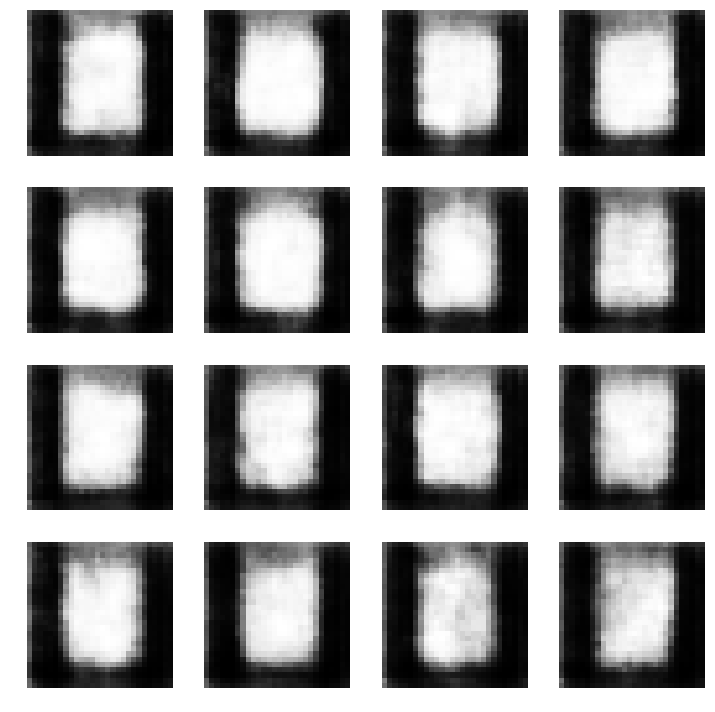

In [21]:
if __name__ == '__main__':
    mnist_dcgan = MNIST_DCGAN()
    timer = ElapsedTimer()
    mnist_dcgan.train(train_step=1000, batch_size=256, save_interval=1)
    timer.elapsed_time()
    mnist_dcgan.plot_images(fake=True)
    mnist_dcgan.plot_images(fake=False, save2file=True)